In [3]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
import numpy as np
import math
from wordcloud import WordCloud
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import warnings
import random

In [2]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357254 sha256=7d056f0d089ddea2785159854d2a2c2c2d6c515f1f1cbe9434529ed67897a6e0
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [6]:
ratings_1m=pd.read_csv("/content/sample_data/ratings.dat", sep='::',header=None, engine='python')
ratings_1m=ratings_1m.rename(columns={0: "UserID", 1: "MovieID", 2: "Rating", 3: "Timestamp"})
movies_1m=pd.read_csv("/content/sample_data/movies.dat", sep='::',header=None, engine='python')
movies_1m=movies_1m.rename(columns={0: "MovieID", 1: "Title", 2: "Genres"})
users_1m=pd.read_csv("/content/sample_data/users.dat", sep='::',header=None, engine='python')
users_1m=users_1m.rename(columns={0: "UserID", 1: "Gender", 2: "Age", 3: "Occupation", 4: "Zip-code"})

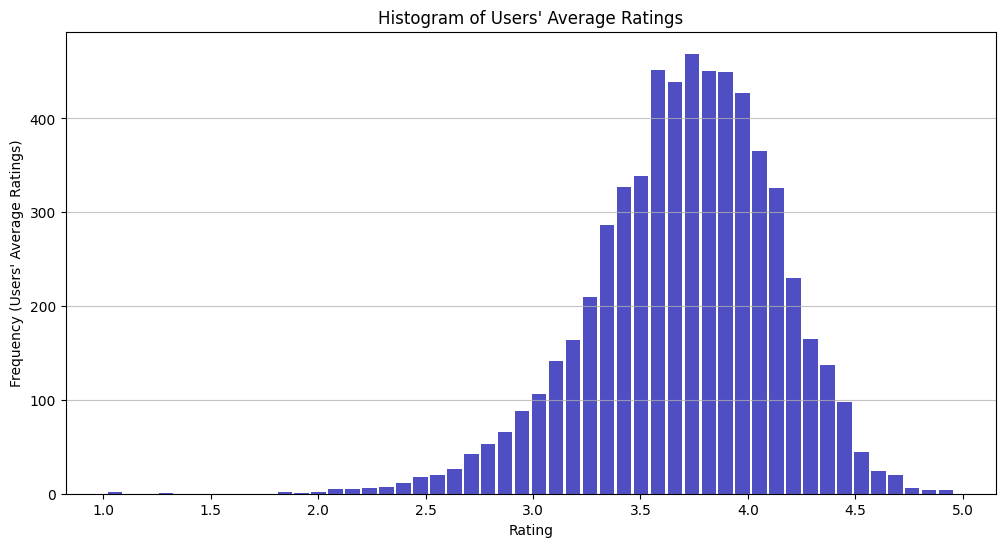

In [7]:
plt.hist(ratings_1m.groupby('UserID')['Rating'].mean().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Users\' Average Ratings)')
plt.title('Histogram of Users\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_average_rating .png', dpi=100)
plt.show()

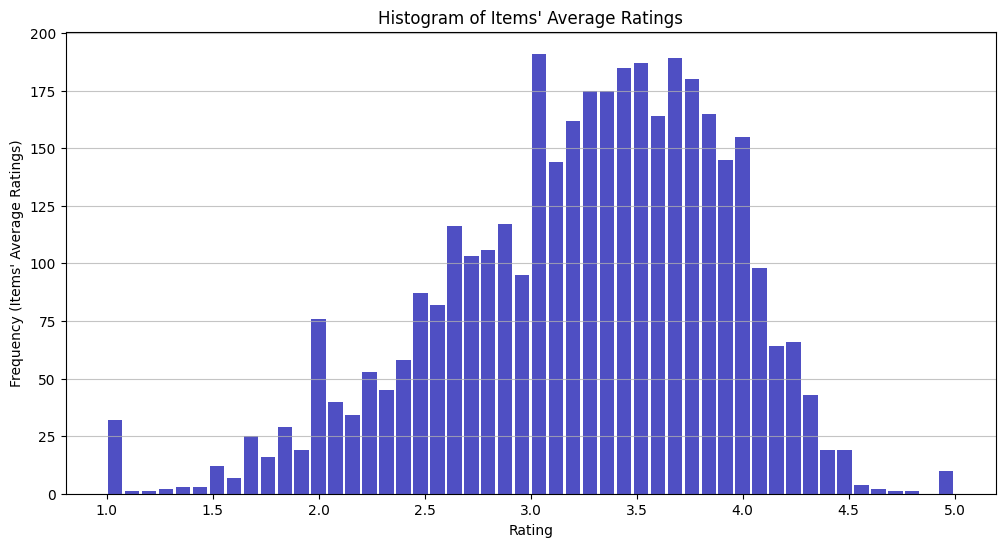

In [8]:
plt.hist(ratings_1m.groupby('MovieID')['Rating'].mean().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Rating')
plt.ylabel('Frequency (Items\' Average Ratings)')
plt.title('Histogram of Items\' Average Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_average_rating.png', dpi=100)
plt.show()

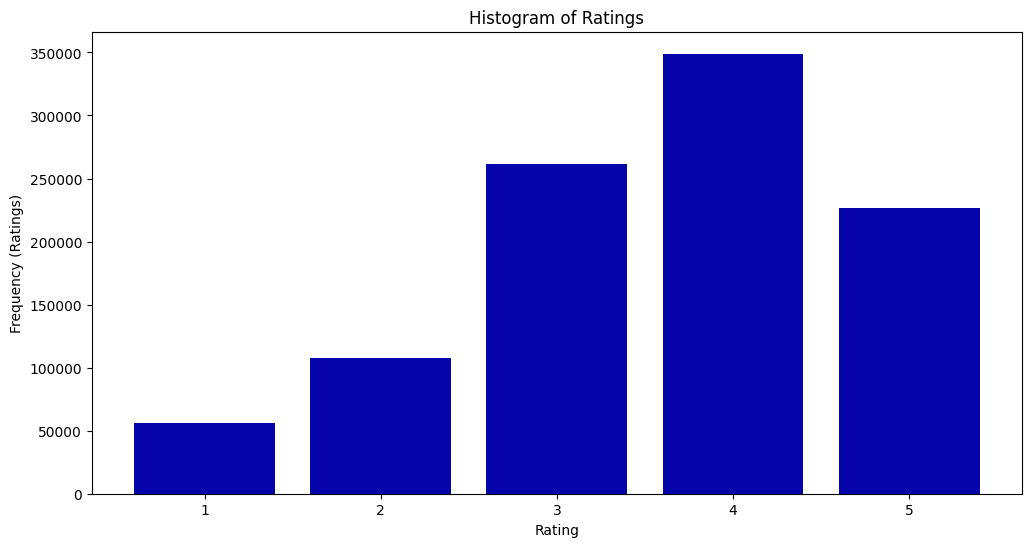

In [9]:
plt.bar(sorted(ratings_1m.Rating.unique()),ratings_1m.groupby('Rating')['UserID'].count(), color='#0504aa')
plt.xlabel('Rating')
plt.ylabel('Frequency (Ratings)')
plt.title('Histogram of Ratings')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('ratings.png', dpi=100)
plt.show()

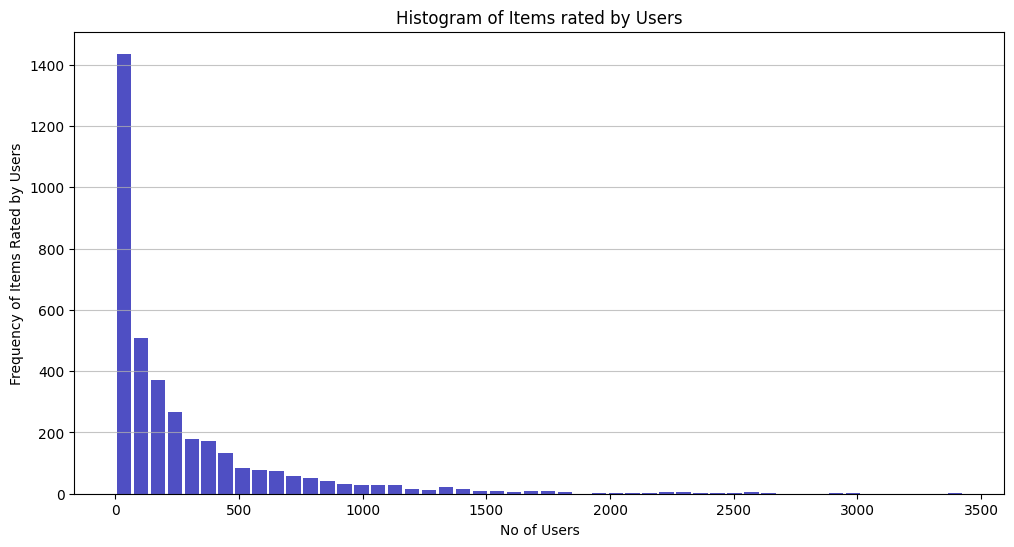

In [10]:
plt.hist(ratings_1m.groupby('MovieID')['UserID'].count().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No of Users')
plt.ylabel('Frequency of Items Rated by Users')
plt.title('Histogram of Items rated by Users')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('items_rated_by_users.png', dpi=100)
plt.show()

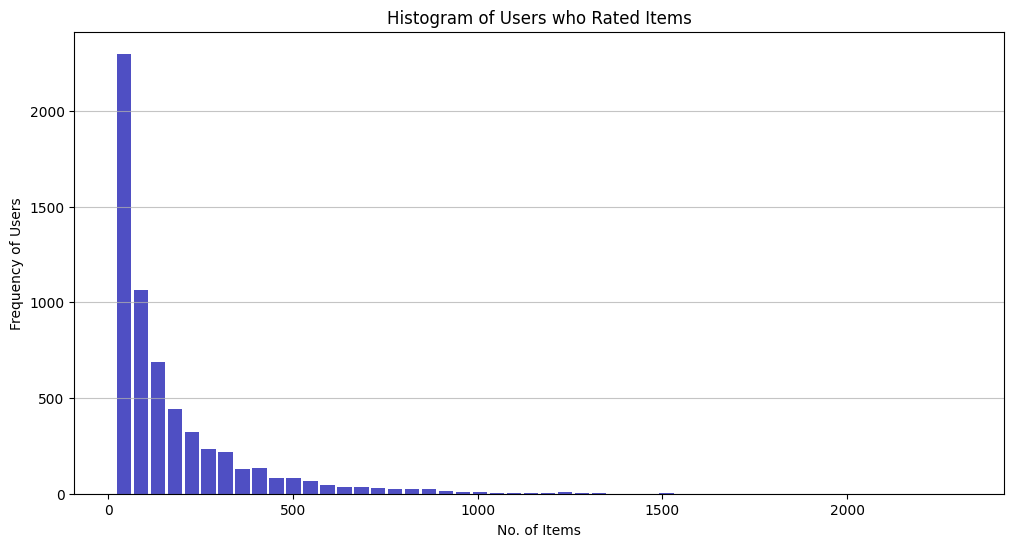

In [11]:
plt.hist(ratings_1m.groupby('UserID')['MovieID'].count().tolist(),bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('No. of Items')
plt.ylabel('Frequency of Users')
plt.title('Histogram of Users who Rated Items')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('users_who_rated_items.png', dpi=100)
plt.show()

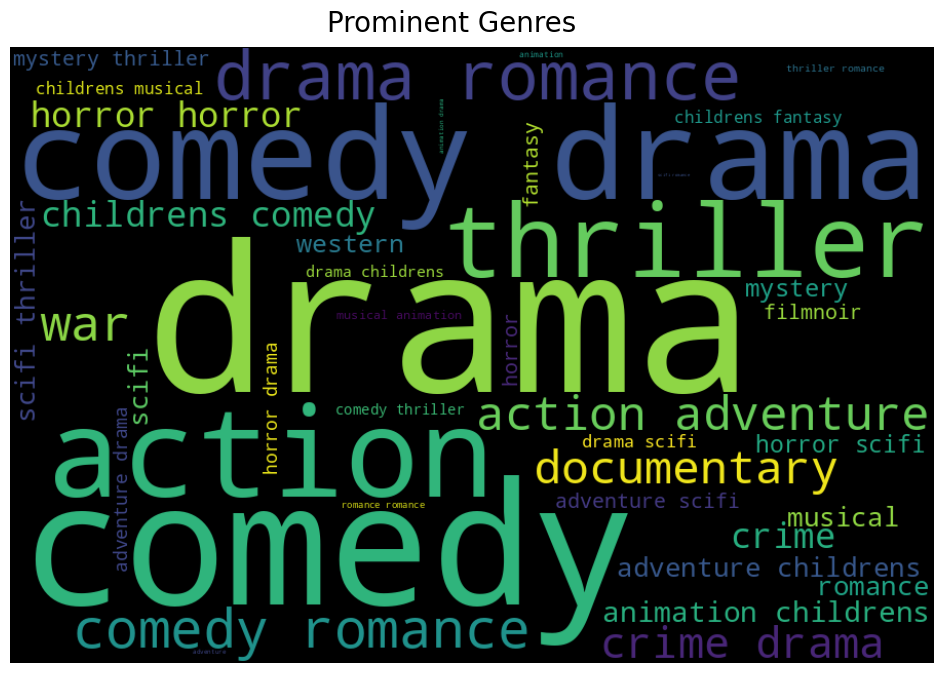

In [12]:
x=movies_1m['Genres'].values.tolist()

all_genres=""
for line in x:
    words=str(line).split("|") #sometimes there were error: 'float' object has no attribute 'split'. That's why cast as a string.
    for word in words:
        word=word.translate(str.maketrans('', '', string.punctuation))
        word=word.lower()
        all_genres=str(all_genres)+" "+str(word)

wordcloud = WordCloud(max_font_size=200, width=900, height=600,collocations=True).generate(all_genres)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.figtext(.5,.9,"Prominent Genres", fontsize=20, ha='center')
fig = plt.gcf()
fig.savefig('wordcloud.png', dpi=100)
plt.show()

In [13]:
from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import cross_validate

reader = Reader()
data = Dataset.load_from_df(ratings_1m[["UserID", "MovieID", "Rating"]], reader)

# use SDV algorithm
algo = SVD()

# run 5-fold cross-validation
x=cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8720  0.8743  0.8715  0.8764  0.8746  0.8738  0.0018  
MAE (testset)     0.6846  0.6862  0.6840  0.6873  0.6872  0.6859  0.0013  
Fit time          19.70   18.07   19.19   18.52   18.33   18.76   0.60    
Test time         1.52    3.38    2.12    2.51    2.11    2.33    0.61    


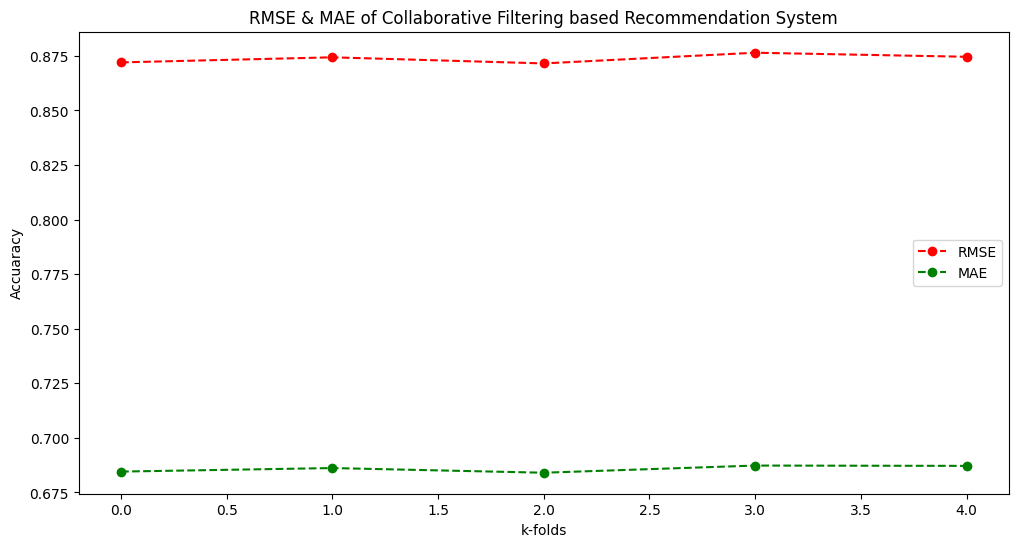

In [14]:
plt.plot(x['test_rmse'], 'ro--', label='RMSE')
plt.plot(x['test_mae'], 'go--', label='MAE')
plt.xlabel('k-folds')
plt.ylabel('Accuaracy')
plt.legend()
plt.title('RMSE & MAE of Collaborative Filtering based Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('cf_rmse_mae.png', dpi=100)
plt.show()

In [15]:
# get top 20 recommendation for a user
titles = movies_1m['Title']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres
def cf_top_reco(userId):
    cf_df=pd.DataFrame()\

    movie_id_list=ratings_1m['MovieID'].unique().tolist()
    est=[]
    movie_name_list=[]
    actual_score_list=[]
    genre_list=[]
    for i in movie_id_list:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        movie_name = movies_1m[movies_1m.MovieID==i]['Title'].values
        movie_name_list.append(movie_name)
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')
    cf_df['movie_id']=movie_id_list
    cf_df['estimated_rating']=est
    cf_df['title']=movie_name_list
    cf_df['actual_rating']=actual_score_list
    cf_df['genres']=genre_list
    cf_df=cf_df.sort_values(['estimated_rating'], ascending=[False])
    return cf_df

In [16]:
userid=1
cf_top_reco(userid).head(20)

,movie_id,estimated_rating,title,actual_rating,genres
23,527,4.844728,[Schindler's List (1993)],[5],[Drama|War]
693,953,4.773292,[It's a Wonderful Life (1946)],[],[Drama]
70,3030,4.770895,[Yojimbo (1961)],[],[Comedy|Drama|Western]
167,318,4.765698,"[Shawshank Redemption, The (1994)]",[],[Drama]
2617,2905,4.764366,[Sanjuro (1962)],[],[Action|Adventure]
39,150,4.750589,[Apollo 13 (1995)],[5],[Drama]
694,954,4.743252,[Mr. Smith Goes to Washington (1939)],[],[Drama]
1448,905,4.738991,[It Happened One Night (1934)],[],[Comedy]
1195,910,4.737691,[Some Like It Hot (1959)],[],[Comedy|Crime]
629,904,4.712570,[Rear Window (1954)],[],[Mystery|Thriller]


In [17]:
# break up the big genre string into a string array
movies_1m['Genres'] = movies_1m['Genres'].str.split('|')
# convert genres to string value
movies_1m['Genres'] = movies_1m['Genres'].fillna("").astype('str')

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=1, stop_words='english')
tfidf_matrix = tf.fit_transform(movies_1m['Genres'])
df = pd.DataFrame(tfidf_matrix.toarray(), columns = tf.get_feature_names_out()) # Use get_feature_names_out() instead of get_feature_names()
print(df)
#tfidf_matrix.shape

      action  action adventure  action animation  action children  \
0        0.0               0.0               0.0              0.0   
1        0.0               0.0               0.0              0.0   
2        0.0               0.0               0.0              0.0   
3        0.0               0.0               0.0              0.0   
4        0.0               0.0               0.0              0.0   
...      ...               ...               ...              ...   
3878     0.0               0.0               0.0              0.0   
3879     0.0               0.0               0.0              0.0   
3880     0.0               0.0               0.0              0.0   
3881     0.0               0.0               0.0              0.0   
3882     0.0               0.0               0.0              0.0   

      action comedy  action crime  action drama  action horror  \
0               0.0           0.0           0.0            0.0   
1               0.0           0.0      

In [20]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[:5, :5]

array([[1.        , 0.14193614, 0.09010857, 0.1056164 , 0.23523322],
       [0.14193614, 1.        , 0.        , 0.        , 0.        ],
       [0.09010857, 0.        , 1.        , 0.1719888 , 0.38306058],
       [0.1056164 , 0.        , 0.1719888 , 1.        , 0.4489859 ],
       [0.23523322, 0.        , 0.38306058, 0.4489859 , 1.        ]])

In [21]:
# build an 1-dimensional array with movie titles
titles = movies_1m['Title']
movie_id = movies_1m['MovieID']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

In [22]:
# function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
#     print(sim_scores)
    sim_scores = sim_scores[1:]
    movie_indices = [i[0] for i in sim_scores]
    cb_df=pd.DataFrame(sim_scores)
    cb_df['title']=titles.iloc[movie_indices].values
    cb_df['movie_id']=movie_id.iloc[movie_indices].values
    cb_df=cb_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    genre_list=[]
    for i in cb_df['movie_id'].values:
        genre = movies_1m[movies_1m.MovieID==i]['Genres'].values
        try:
            genre_list.append(genre)
        except:
            genre_list.append('Unavailable')
    cb_df['genres']=genre_list
    return cb_df

In [23]:
movies_1m[movies_1m.Title=='Toy Story (1995)']

,MovieID,Title,Genres
0,1,Toy Story (1995),"['Animation', ""Children's"", 'Comedy']"


In [24]:
title='Toy Story (1995)'
genre_recommendations(title).head(20)

,movie_index,similarity_score,title,movie_id,genres
0,1050,1.000000,Aladdin and the King of Thieves (1996),1064,"[['Animation', ""Children's"", 'Comedy']]"
1,2072,1.000000,"American Tail, An (1986)",2141,"[['Animation', ""Children's"", 'Comedy']]"
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",2142,"[['Animation', ""Children's"", 'Comedy']]"
3,2285,1.000000,"Rugrats Movie, The (1998)",2354,"[['Animation', ""Children's"", 'Comedy']]"
4,2286,1.000000,"Bug's Life, A (1998)",2355,"[['Animation', ""Children's"", 'Comedy']]"
5,3045,1.000000,Toy Story 2 (1999),3114,"[['Animation', ""Children's"", 'Comedy']]"
6,3542,1.000000,Saludos Amigos (1943),3611,"[['Animation', ""Children's"", 'Comedy']]"
7,3682,1.000000,Chicken Run (2000),3751,"[['Animation', ""Children's"", 'Comedy']]"
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3754,"[['Animation', ""Children's"", 'Comedy']]"
9,236,0.869805,"Goofy Movie, A (1995)",239,"[['Animation', ""Children's"", 'Comedy', 'Romanc..."


In [25]:
# an 1-dimensional array with movie titles
titles = movies_1m['Title']
indices = pd.Series(movies_1m.index, index=movies_1m['Title'])

# function that get movie recommendations based on the cosine similarity score of movie genres and estimate the rating
# given the particular user

def hybrid_recommendations(userId,title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:100]
    movie_indices = [i[0] for i in sim_scores]
    hybrid_df=pd.DataFrame(sim_scores)
    hybrid_df['title']=titles.iloc[movie_indices].values
    est=[]
    actual_score_list=[]
    hybrid_df=hybrid_df.rename(columns={0: "movie_index", 1: "similarity_score"})
    for i in movie_indices:
        pred = algo.predict(userId, i, verbose=False)
        est.append(pred[3])
        actual_score =  ratings_1m[(ratings_1m.MovieID==i)&(ratings_1m.UserID==userId)]['Rating'].values
        actual_score_list.append(actual_score)
    hybrid_df['estimated_rating']=est
    hybrid_df['actual_rating']=actual_score_list
    hybrid_df=hybrid_df.sort_values(['similarity_score','estimated_rating'], ascending=[False,False])
    return hybrid_df

In [26]:
userid=1
title='Toy Story (1995)'
hybrid_recommendations(userid, title).head(20)

,movie_index,similarity_score,title,estimated_rating,actual_rating
0,1050,1.000000,Aladdin and the King of Thieves (1996),4.340616,[]
3,2285,1.000000,"Rugrats Movie, The (1998)",4.178919,[]
2,2073,1.000000,"American Tail: Fievel Goes West, An (1991)",4.120088,[]
6,3542,1.000000,Saludos Amigos (1943),3.878241,[]
7,3682,1.000000,Chicken Run (2000),3.704826,[]
8,3685,1.000000,"Adventures of Rocky and Bullwinkle, The (2000)",3.676738,[]
5,3045,1.000000,Toy Story 2 (1999),3.538867,[]
1,2072,1.000000,"American Tail, An (1986)",3.189458,[]
4,2286,1.000000,"Bug's Life, A (1998)",2.785828,[]
9,236,0.869805,"Goofy Movie, A (1995)",3.571168,[]


In [27]:
warnings.filterwarnings("ignore")

In [28]:
rmse_val_sum=0
rmse_count=0
hybrid_rmse_val=[]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users:
for j in range(20):
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))

    y = float(rmse_val)
    if math.isnan(y)==False:
        hybrid_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1
    if rmse_count==10:
        break

hybrid_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for hybrid system:",hybrid_avg_rmse)


Average RMSE for hybrid system: 0.5467800374031495


In [29]:
rmse_val_sum=0
rmse_count=0
cf_rmse_val=[]

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users:
for j in range(20):
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    rmse_val = rmse(np.array(y_pred), np.array(y_actual))

    y = float(rmse_val)
    if math.isnan(y)==False:
        cf_rmse_val.append(rmse_val)
        rmse_val_sum=rmse_val_sum+rmse_val
        rmse_count=rmse_count+1
    if rmse_count==10:
        break

cf_avg_rmse=rmse_val_sum/rmse_count
print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.6938180638881706


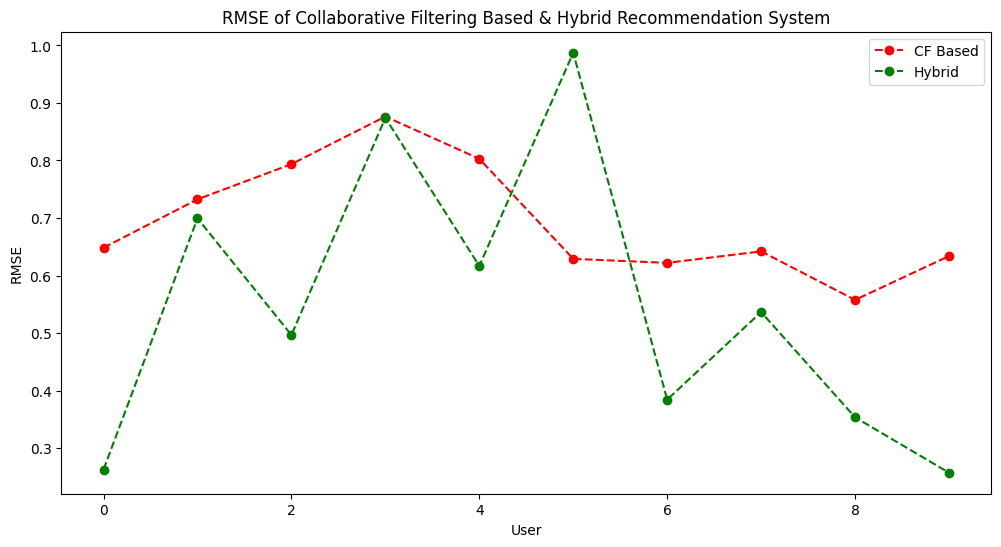

In [30]:
plt.plot(cf_rmse_val, 'ro--', label='CF Based')
plt.plot(hybrid_rmse_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse.png', dpi=100)
plt.show()

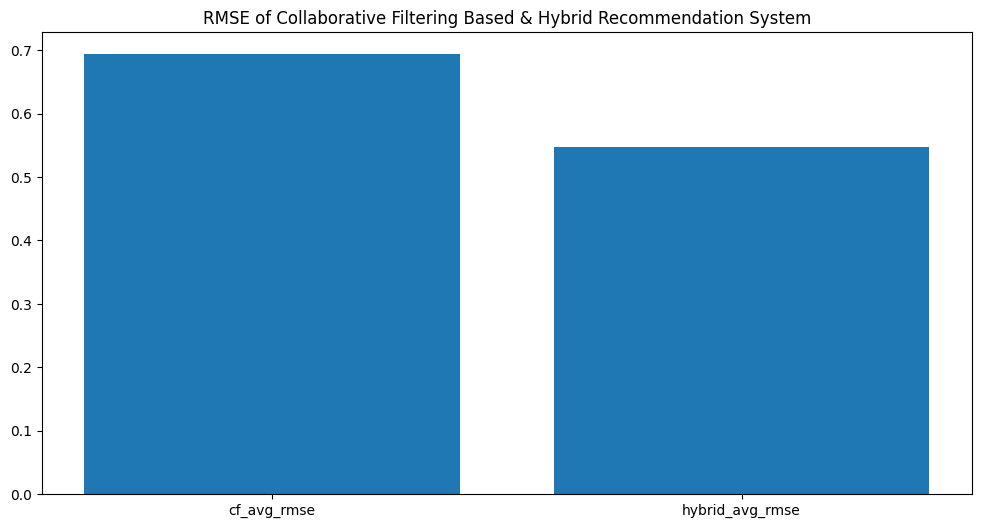

In [31]:
plt.bar(['cf_avg_rmse','hybrid_avg_rmse'],[cf_avg_rmse,hybrid_avg_rmse])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse_avg.png', dpi=100)
plt.show()

In [32]:
mae_val_sum=0
mae_count=0
hybrid_mae_val=[]

def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(100)
# random_users = random.sample(range(6040), 10)

# for j in random_users:
for j in range(20):
    x=hybrid_recommendations(j, 'Toy Story (1995)')
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))

    y = float(mae_val)
    if math.isnan(y)==False:
        hybrid_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1
    if mae_count==10:
        break

hybrid_avg_mae=mae_val_sum/mae_count
print("Average MAE for hybrid system:",hybrid_avg_mae)

Average MAE for hybrid system: 0.49437783623386944


In [33]:
mae_val_sum=0
mae_count=0
cf_mae_val=[]

def mae(predictions, targets):
    return (abs(predictions - targets).mean())

# random.seed(0)
# random_users = random.sample(range(6040), 10)

# for j in random_users:
for j in range(20):
    x=cf_top_reco(j)
    rating_sum=0
    count=0
    y_actual=[]
    y_pred=[]
    for i in range(len(x)):
        if x.iloc[i]['actual_rating'].size>0:
            y_actual.append((int(x.iloc[i]['actual_rating'])))
            y_pred.append((x.iloc[i]['estimated_rating']))

    mae_val = mae(np.array(y_pred), np.array(y_actual))

    y = float(mae_val)
    if math.isnan(y)==False:
        cf_mae_val.append(mae_val)
        mae_val_sum=mae_val_sum+mae_val
        mae_count=mae_count+1
    if mae_count==10:
        break

cf_avg_mae=mae_val_sum/mae_count
print("Average MAE for collaborative filtering based system:",cf_avg_mae)


Average MAE for collaborative filtering based system: 0.5526992472630227


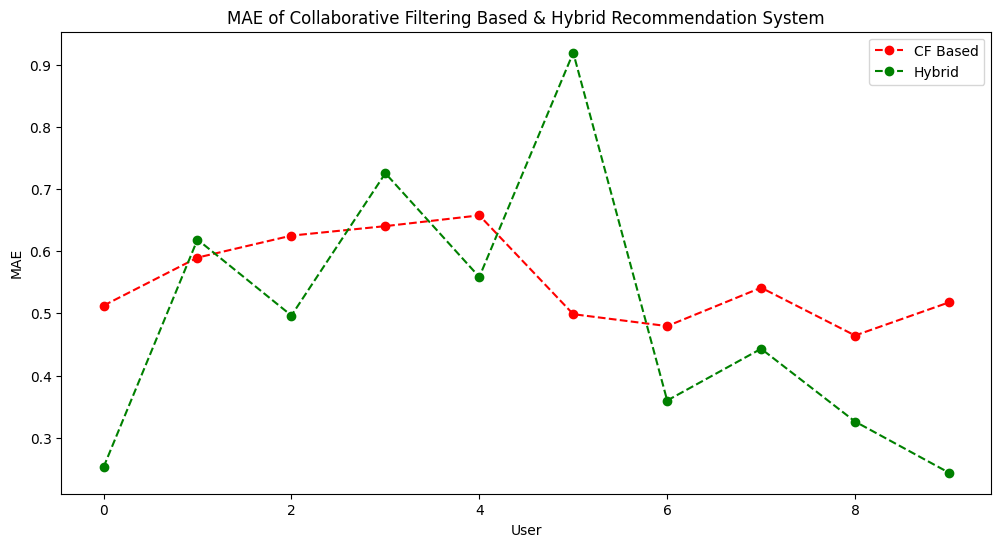

In [34]:
plt.plot(cf_mae_val, 'ro--', label='CF Based')
plt.plot(hybrid_mae_val, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae.png', dpi=100)
plt.show()

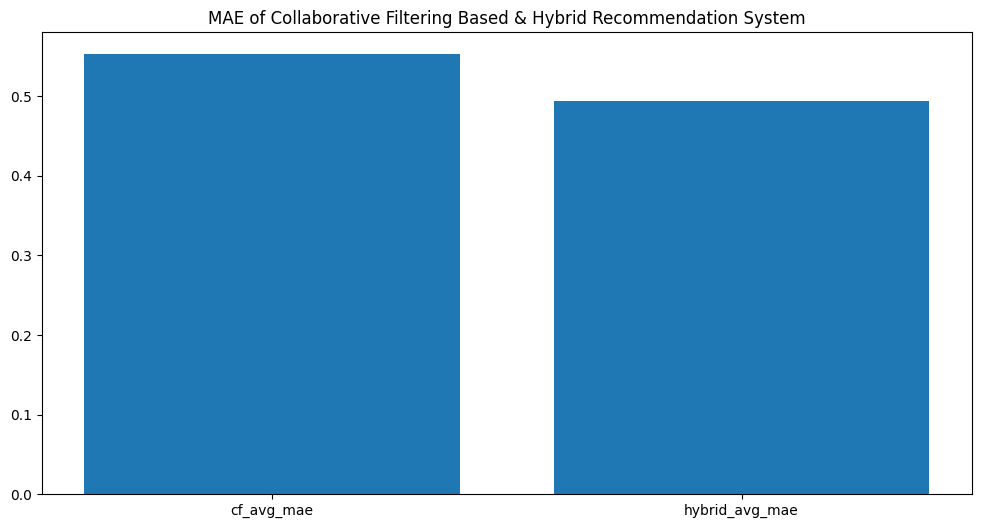

In [35]:
plt.bar(['cf_avg_mae','hybrid_avg_mae'],[cf_avg_mae,hybrid_avg_mae])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae_avg.png', dpi=100)
plt.show()

In [36]:
all_hybrid_avg_rmse=[]
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    hybrid_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10):
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            hybrid_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1
        if rmse_count==5:
            break

    hybrid_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for hybrid system:",hybrid_avg_rmse)
    all_hybrid_avg_rmse.append(hybrid_avg_rmse)

all_hybrid_avg_rmse_one=sum(all_hybrid_avg_rmse)/len(all_hybrid_avg_rmse)

Average RMSE for hybrid system: 0.5898686156757647
Average RMSE for hybrid system: 0.4404699713137668
Average RMSE for hybrid system: 0.6852813142979474
Average RMSE for hybrid system: 0.7408240451764142
Average RMSE for hybrid system: 0.7152874870014008


In [37]:
all_cf_avg_rmse=[]
for k in range(5):
    rmse_val_sum=0
    rmse_count=0
    cf_rmse_val=[]

    def rmse(predictions, targets):
        return np.sqrt(((predictions - targets) ** 2).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10):
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        rmse_val = rmse(np.array(y_pred), np.array(y_actual))

        y = float(rmse_val)
        if math.isnan(y)==False:
            cf_rmse_val.append(rmse_val)
            rmse_val_sum=rmse_val_sum+rmse_val
            rmse_count=rmse_count+1
        if rmse_count==5:
            break

    cf_avg_rmse=rmse_val_sum/rmse_count
    print("Average RMSE for collaborative filtering based system:",cf_avg_rmse)
    all_cf_avg_rmse.append(cf_avg_rmse)

all_cf_avg_rmse_one=sum(all_cf_avg_rmse)/len(all_cf_avg_rmse)

Average RMSE for collaborative filtering based system: 0.7707746747217673
Average RMSE for collaborative filtering based system: 0.7850626368592069
Average RMSE for collaborative filtering based system: 0.760158349386021
Average RMSE for collaborative filtering based system: 0.7643996412701309
Average RMSE for collaborative filtering based system: 0.7876369082382887


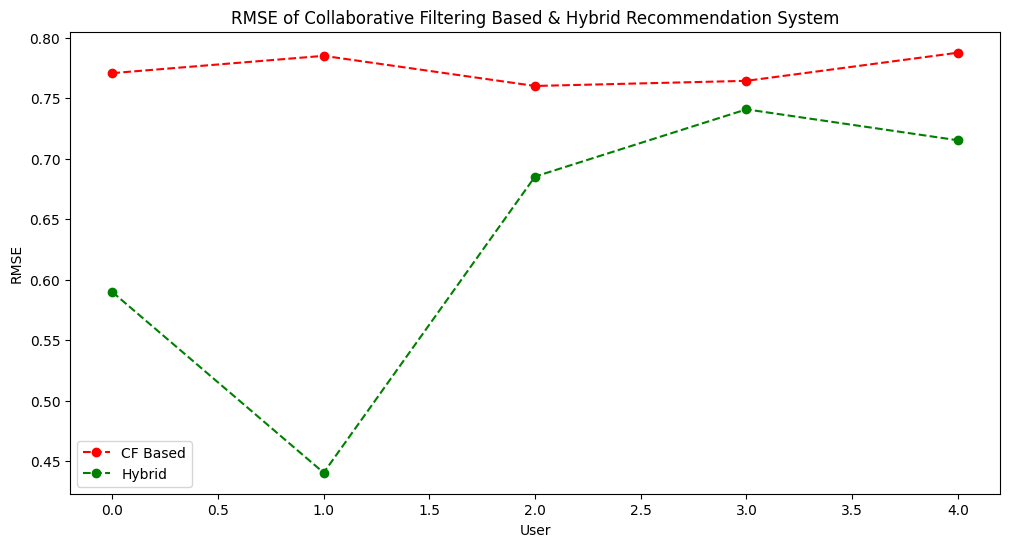

In [38]:
plt.plot(all_cf_avg_rmse, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_rmse, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('all_hybrid_cf_rmse.png', dpi=100)
plt.show()

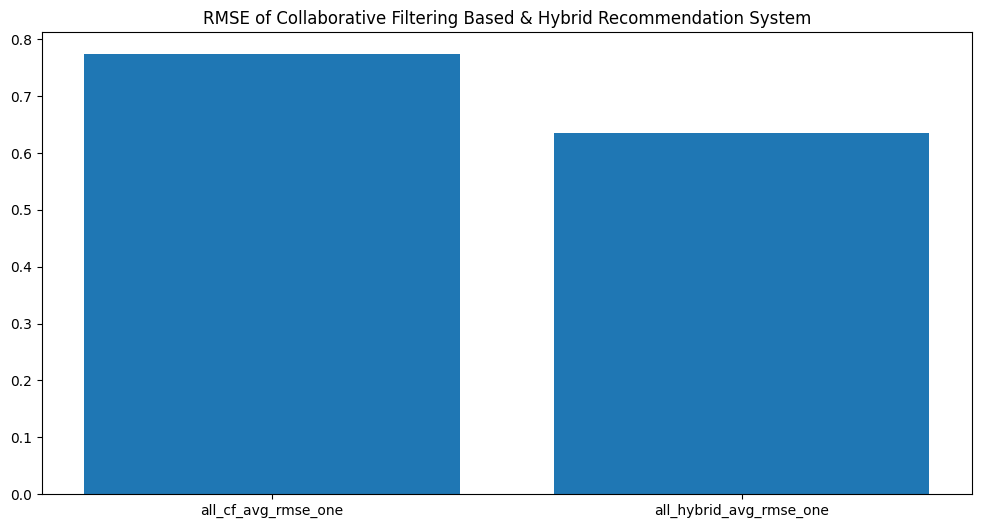

In [39]:
plt.bar(['all_cf_avg_rmse_one','all_hybrid_avg_rmse_one'],[all_cf_avg_rmse_one,all_hybrid_avg_rmse_one])
plt.title('RMSE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_rmse_avg_one.png', dpi=100)
plt.show()

In [40]:
all_hybrid_avg_mae=[]
for k in range(5):
    mae_val_sum=0
    mae_count=0
    hybrid_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10):
        x=hybrid_recommendations(j, 'Toy Story (1995)')
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            hybrid_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1
        if mae_count==5:
            break

    hybrid_avg_mae=mae_val_sum/mae_count
    print("Average MAE for hybrid system:",hybrid_avg_mae)
    all_hybrid_avg_mae.append(hybrid_avg_mae)

all_hybrid_avg_mae_one=sum(all_hybrid_avg_mae)/len(all_hybrid_avg_rmse)

Average MAE for hybrid system: 0.5303590684623753
Average MAE for hybrid system: 0.38815374241770695
Average MAE for hybrid system: 0.6153677088878038
Average MAE for hybrid system: 0.6115272415418689
Average MAE for hybrid system: 0.6130025999717855


In [41]:
all_cf_avg_mae=[]
for k in range(5):
    mae_val_sum=0
    mae_count=0
    cf_mae_val=[]

    def mae(predictions, targets):
        return (abs(predictions - targets).mean())

#     random.seed(k)
#     random_users = random.sample(range(6040), 20)

    first=k*10

    for j in range(first,first+10):
        x=cf_top_reco(j)
        rating_sum=0
        count=0
        y_actual=[]
        y_pred=[]
        for i in range(len(x)):
            if x.iloc[i]['actual_rating'].size>0:
                y_actual.append((int(x.iloc[i]['actual_rating'])))
                y_pred.append((x.iloc[i]['estimated_rating']))

        mae_val = mae(np.array(y_pred), np.array(y_actual))

        y = float(mae_val)
        if math.isnan(y)==False:
            cf_mae_val.append(mae_val)
            mae_val_sum=mae_val_sum+mae_val
            mae_count=mae_count+1
        if mae_count==5:
            break

    cf_avg_mae=mae_val_sum/mae_count
    print("Average MAE for collaborative filtering based system:",cf_avg_mae)
    all_cf_avg_mae.append(cf_avg_mae)

all_cf_avg_mae_one=sum(all_cf_avg_mae)/len(all_cf_avg_mae)

Average MAE for collaborative filtering based system: 0.605047563165998
Average MAE for collaborative filtering based system: 0.6449806764368716
Average MAE for collaborative filtering based system: 0.6271737999260042
Average MAE for collaborative filtering based system: 0.6108398420357906
Average MAE for collaborative filtering based system: 0.6531885356681547


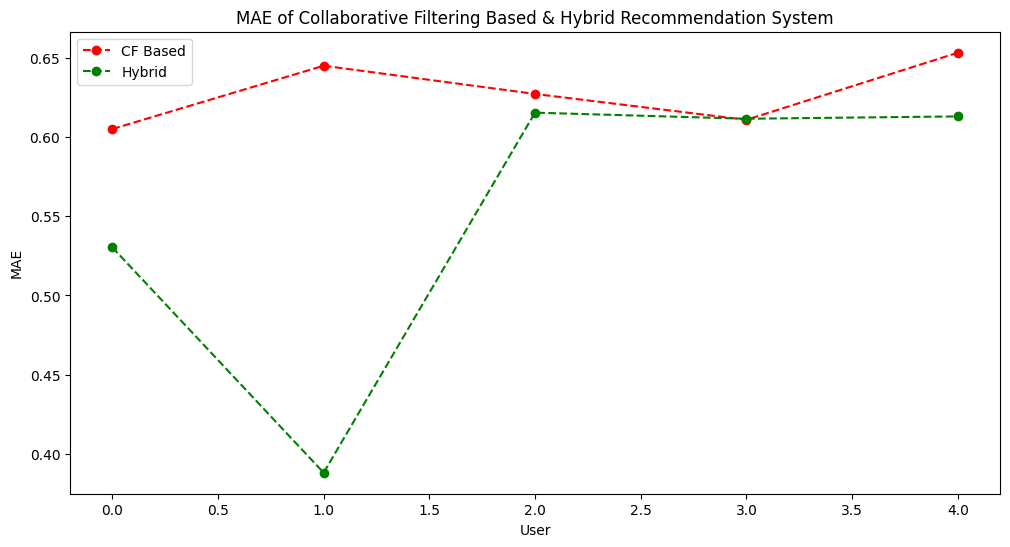

In [42]:
plt.plot(all_cf_avg_mae, 'ro--', label='CF Based')
plt.plot(all_hybrid_avg_mae, 'go--', label='Hybrid')
plt.xlabel('User')
plt.ylabel('MAE')
plt.legend()
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('set_all_hybrid_cf_mae.png', dpi=100)
plt.show()

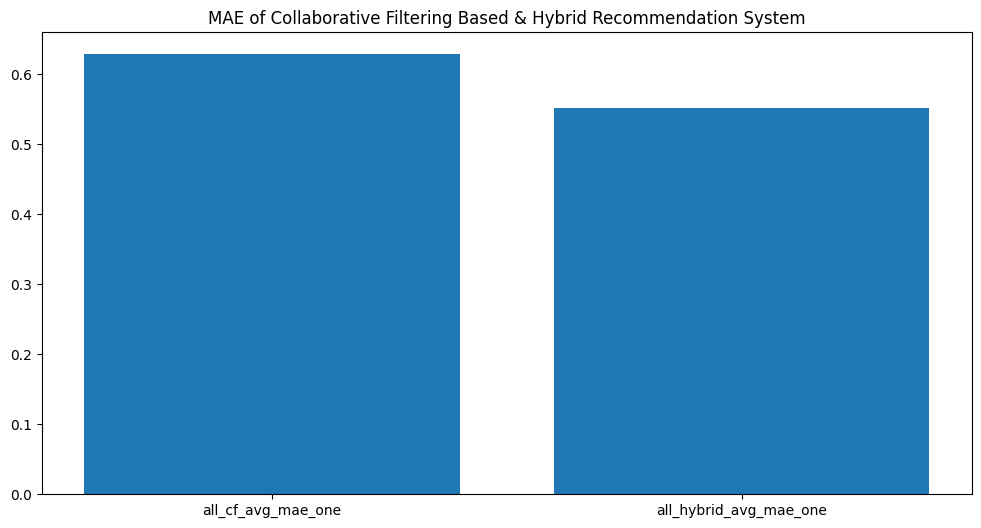

In [44]:
plt.bar(['all_cf_avg_mae_one','all_hybrid_avg_mae_one'],[all_cf_avg_mae_one,all_hybrid_avg_mae_one])
plt.title('MAE of Collaborative Filtering Based & Hybrid Recommendation System')
fig = plt.gcf()
fig.set_size_inches(12, 6)
fig.savefig('hybrid_cf_mae_avg_one.png', dpi=100)
plt.show()